In [2]:
import numpy as np
import os
import sys

import matplotlib.pyplot as plt

In [3]:
#to calculate the net charge in pymol (assuming neutral his/cys/tyr):
#print(cmd.count_atoms("resn lys and name CA") + cmd.count_atoms("resn arg and name CA") - cmd.count_atoms("resn asp and name CA") - cmd.count_atoms("resn glu and name CA"))

In [4]:
#from https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """

    stds = []
    for v in values:
        average = np.average(v, weights=weights)
        # Fast and numerically precise:
        stds.append(np.sqrt(np.average((v-average)**2, weights=weights)))

    return stds

/tmp/ipykernel_127137/954043261.py:60: RuntimeWarning: divide by zero encountered in divide
  enrichments_2d = np.divide(aa_rdf_all, popc_rdf_all)
/tmp/ipykernel_127137/954043261.py:60: RuntimeWarning: invalid value encountered in divide
  enrichments_2d = np.divide(aa_rdf_all, popc_rdf_all)
/tmp/ipykernel_127137/1505087110.py:16: RuntimeWarning: invalid value encountered in subtract
  stds.append(np.sqrt(np.average((v-average)**2, weights=weights)))
/tmp/ipykernel_127137/954043261.py:81: RuntimeWarning: invalid value encountered in double_scalars
  mole_fraction_aa = [aad/ttd for aad, ttd in zip(mean_aa_density, total_molar_density)]


(200,)
(6, 200)
aac1 bulk mol fraction: 0.04058886840445297
aac1 1-nm mol fraction: 0.10697042045641798
aac1 1-nm/bulk enrichment = 2.6354620037813703
(200,)
(6, 200)
ucp1 bulk mol fraction: 0.05619328171675122
ucp1 1-nm mol fraction: 0.12624421383237105
ucp1 1-nm/bulk enrichment = 2.246606889213549
(200,)
(6, 200)
aac1 bulk mol fraction: 0.04051959196675387
aac1 1-nm mol fraction: 0.1533912183158425
aac1 1-nm/bulk enrichment = 3.78560619370746
(200,)
(6, 200)
ucp1 bulk mol fraction: 0.04950302174720891
ucp1 1-nm mol fraction: 0.14423560564791682
ucp1 1-nm/bulk enrichment = 2.9136727528365305


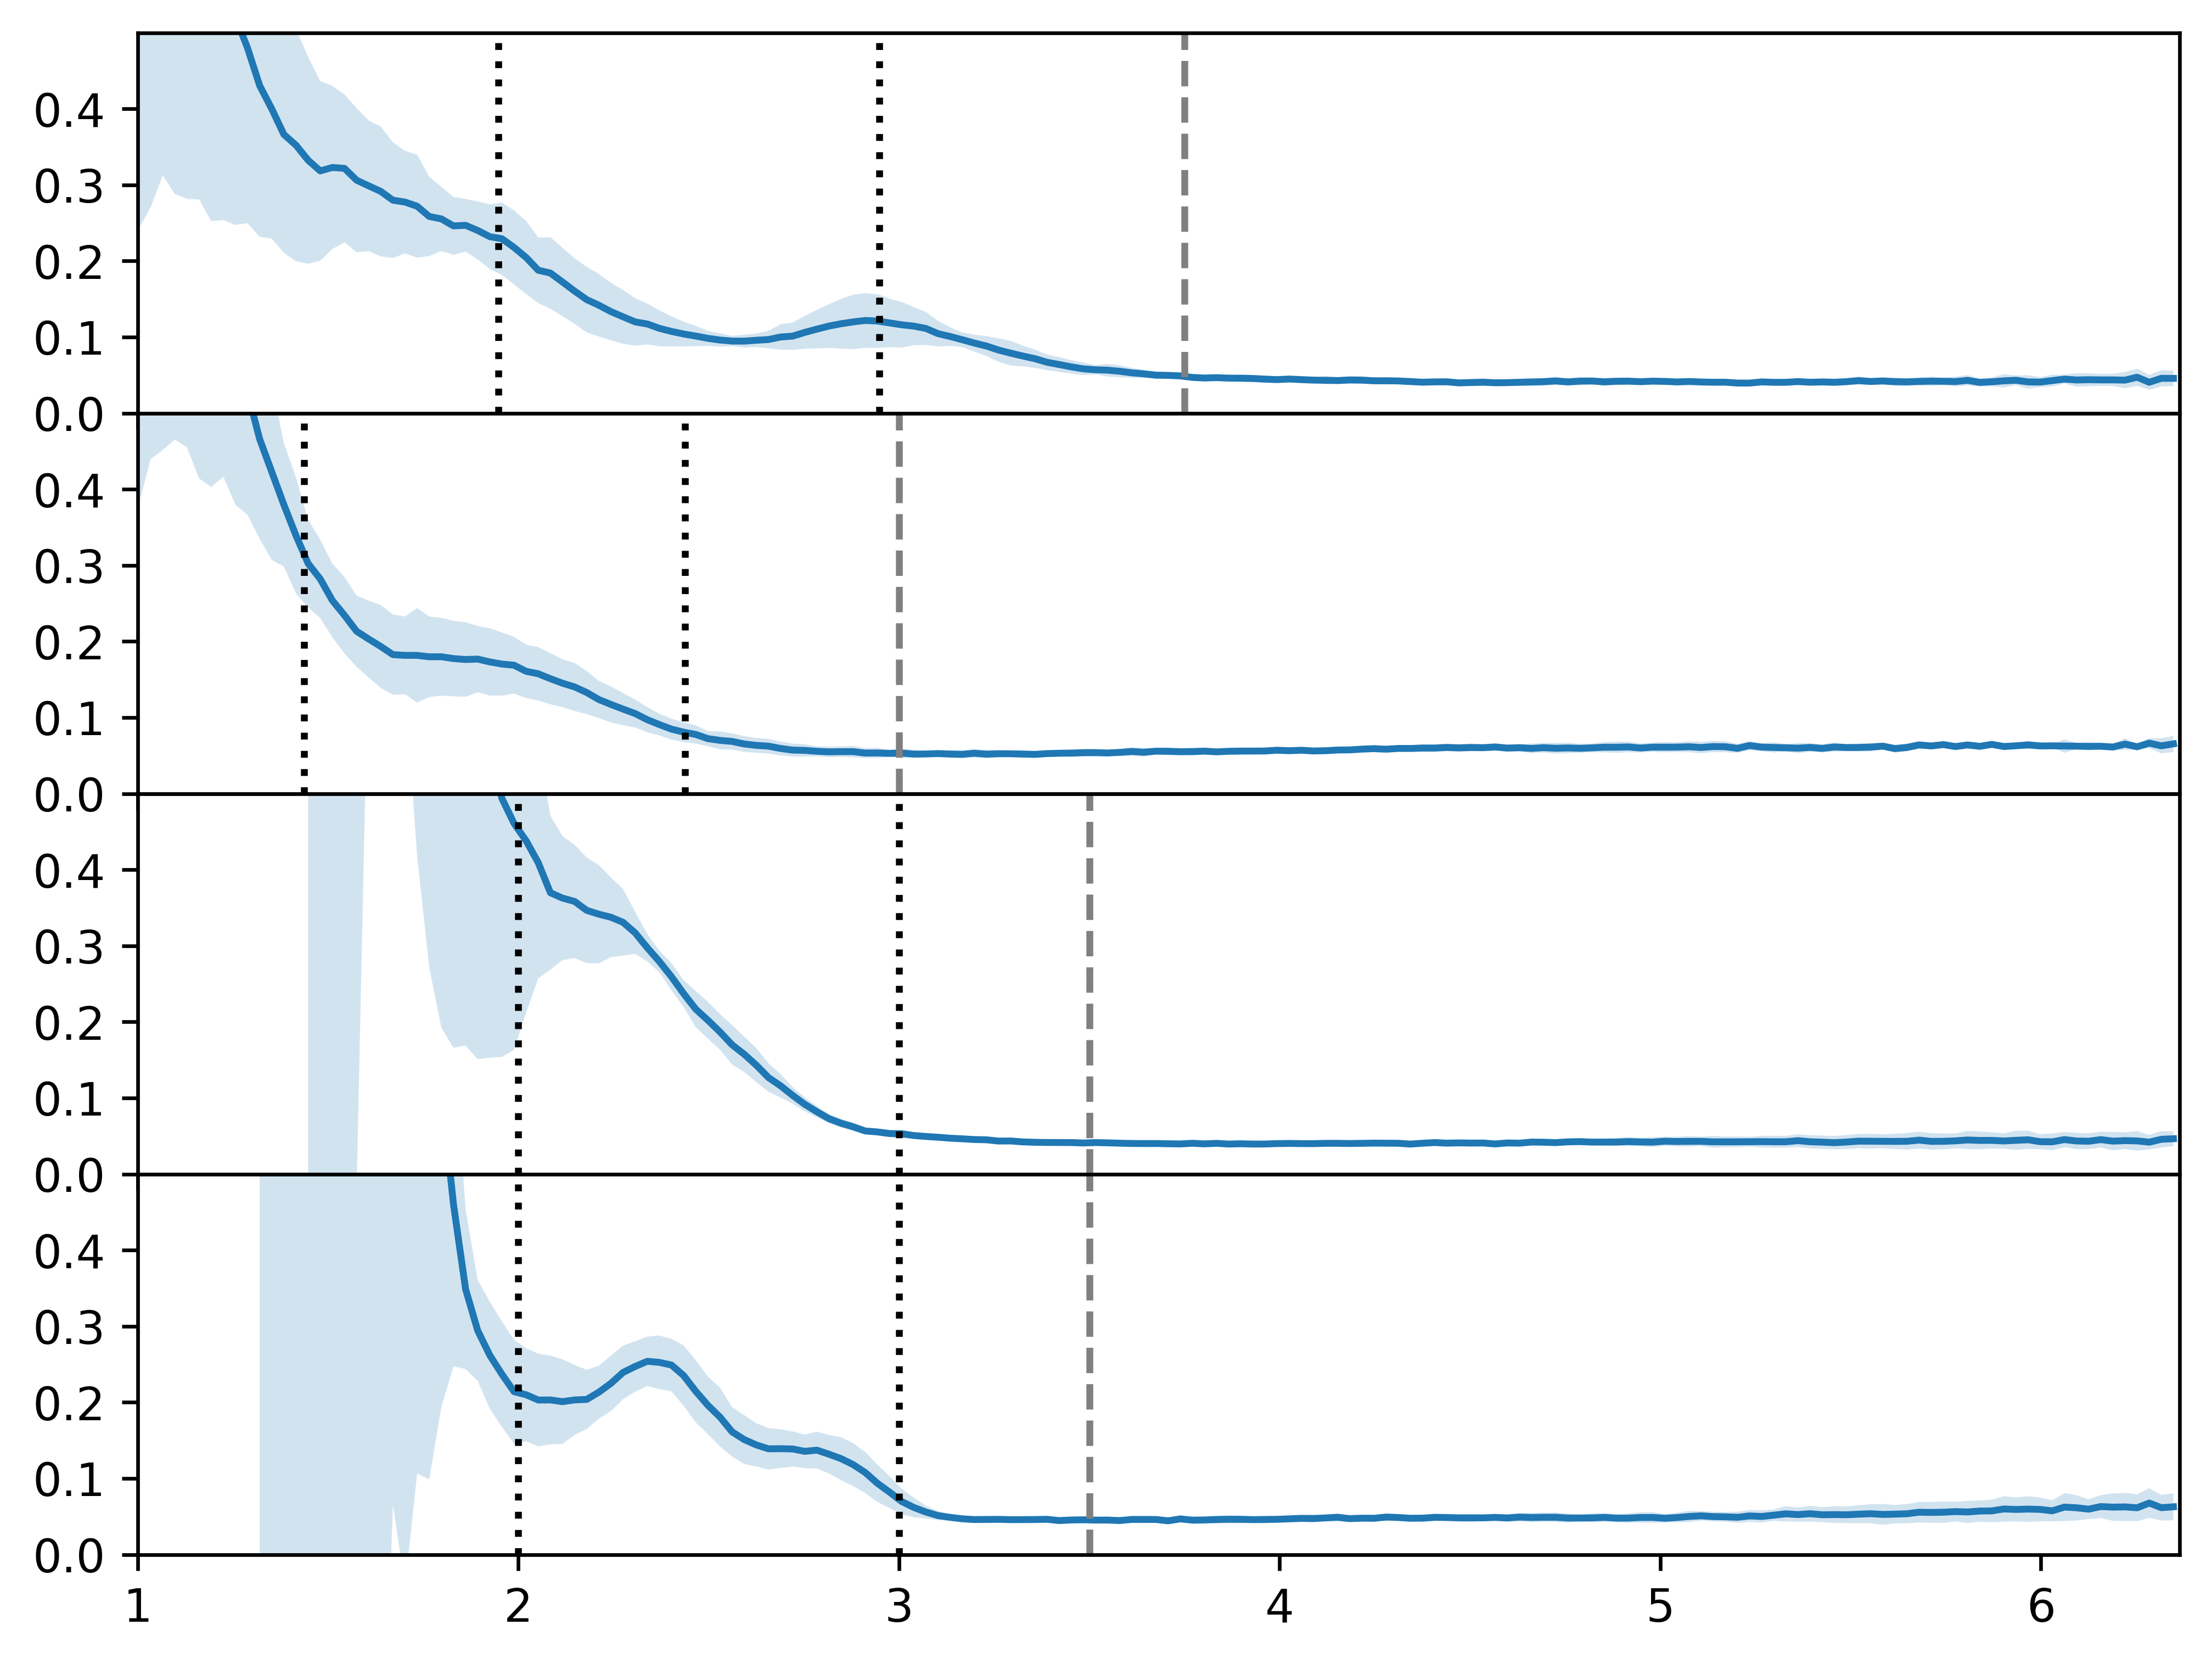

In [6]:
def rdf_2_figure():

    inputpath = "/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/rdfs/outputs"

    servers = ["wynton", "degrabo"]

    zonecolors = {"aac1":"black", "ucp1":"grey"}
    colors = ["cyan", "blue", "orange", "red"]

    #plt.figure(figsize = (15,6), dpi=600)

    #fig, ax1 = plt.subplots(figsize = (15,6), dpi=600)
    #ax2 = ax1.twinx()

    fig = plt.figure(figsize = (8,6), dpi=600)
    gs = fig.add_gridspec(4, hspace=0) #-0.2 works otherwise
    axs = gs.subplots(sharex=True, sharey=True)

    ci = 0

    legend1 = []
    legend2 = []

    for leaflet in ["upper", "lower"]:

        for protein in ["aac1","ucp1"]:

            bincenters_all = []
            aa_rdf_all = []
            popc_rdf_all = []
            helices_all = []

            for server in servers:
                for run in range(1,5):
                    if server == "degrabo" and run > 2:
                        continue

                    bincenters = np.load(f"{inputpath}/{server}/{protein}/run0{run}/{protein}-{server}-run{str(run).zfill(2)}-ARAN-{leaflet}-bincenters.npy")
                    aa_rdf = np.load(f"{inputpath}/{server}/{protein}/run0{run}/{protein}-{server}-run{str(run).zfill(2)}-ARAN-{leaflet}-rdf.npy")
                    popc_rdf = np.load(f"{inputpath}/{server}/{protein}/run0{run}/{protein}-{server}-run{str(run).zfill(2)}-POPC-{leaflet}-rdf.npy")
                    helices = np.load(f"{inputpath}/{server}/{protein}/run0{run}/{protein}-{server}-run{str(run).zfill(2)}-ARAN-{leaflet}-helix-radii.npy")
                
                    aa_rdf_all.append(aa_rdf[-1])
                    popc_rdf_all.append(popc_rdf[-1])
                    bincenters_all.append(bincenters[-1])
                    helices_all.append(helices[-1])


            #simulation length (*100 ps) by simulation and protein
            nframes = {"aac1":[35242, 35336, 58325/2, 58169/2, 25043, 37351], "ucp1":[37084, 36265, 55026/2, 48309/2, 32256, 29577]}

            #average across 6 runs
            bincenters = bincenters_all[0] #all runs use the same bincenters
            mean_helix_radii = np.mean(np.stack(helices_all), axis = 0)
            mean_aa_density = np.average(np.stack(aa_rdf_all), axis = 0, weights = nframes[protein])
            std_aa_density = weighted_std(np.stack(aa_rdf_all).transpose(), np.array(nframes[protein])) #np.std(np.stack(aa_rdf_all), axis = 0)#, weights = nframes[protein])

            mean_popc_density = np.average(np.stack(popc_rdf_all), axis = 0, weights = nframes[protein])

            enrichments_2d = np.divide(aa_rdf_all, popc_rdf_all)

            print(bincenters.shape)
            print(enrichments_2d.shape)

            mean_enrichments = np.average(np.stack(enrichments_2d), axis = 0, weights = nframes[protein])
            std_enrichments = weighted_std(np.stack(enrichments_2d).transpose(), np.array(nframes[protein]))

            axs[ci].plot(bincenters, mean_enrichments) #, color=colors[ci]
            axs[ci].fill_between(bincenters, mean_enrichments+std_enrichments, mean_enrichments-std_enrichments, alpha = 0.2, linewidth = 0, label="_nolegend_") #color=colors[ci], 
    
            #print(mean_aa_density.shape)

            total_molar_density = mean_aa_density+mean_popc_density
            
            # ax1.plot(bincenters, mean_aa_density, color=colors[ci])
            # ax1.fill_between(bincenters, mean_aa_density+std_aa_density, mean_aa_density-std_aa_density, color=colors[ci], alpha = 0.2, linewidth = 0, label="_nolegend_")
            # legend1.append(f"{protein.upper()} AA density")


            #calculate mole fraction of AA as a function of radius
            mole_fraction_aa = [aad/ttd for aad, ttd in zip(mean_aa_density, total_molar_density)]

            prot_zone_length = 1 #{"aac1":1, "ucp1":1}

            #calculate mole fraction of AA in the near-protein and bulk membrane
            if leaflet == "upper":
                prot_zone_min = np.max(mean_helix_radii) #need a different number for M side, 2 would probably work
                bulk_min = {"aac1":3.75, "ucp1":3}
                bulk_min = bulk_min[protein]
            elif leaflet == "lower":
                prot_zone_min = 2
                bulk_min = 3.5

            axs[ci].axvline(prot_zone_min, color = "black", linestyle = "dotted", label="_nolegend_")
            axs[ci].axvline(prot_zone_min+prot_zone_length, color = "black", linestyle = "dotted", label="_nolegend_")

            axs[ci].axvline(bulk_min, color = "grey", linestyle = "dashed", label="_nolegend_")


            aa_bulk_density = []

            aa_nearprot = 0
            aa_bulk = 0
            popc_nearprot = 0
            popc_bulk = 0
            
            for bc, aa_density, popc_density in zip(bincenters, mean_aa_density, mean_popc_density):
                if bc >= prot_zone_min and bc < prot_zone_min + prot_zone_length:
                    aa_nearprot += bc*aa_density
                    popc_nearprot += bc*popc_density
                elif bc >= bulk_min:
                    aa_bulk += bc*aa_density
                    popc_bulk += bc*popc_density 
                    aa_bulk_density.append(aa_density)           

            bulk_mol_fraction = aa_bulk/(aa_bulk+popc_bulk)
            nearprot_mol_fraction = aa_nearprot/(aa_nearprot+popc_nearprot)

            mean_aa_bulk_density = np.mean(aa_bulk_density)

            #mole_fraction_rescaled = np.array(mole_fraction_aa)*mean_aa_bulk_density/bulk_mol_fraction

            # axs[ci].plot(bincenters, mole_fraction_aa, color = colors[ci])
            # legend2.append(f"{protein.upper()} AA mol fraction")

            # plt.axhline(bulk_mol_fraction)
            # plt.axhline(nearprot_mol_fraction)

            print(f"{protein} bulk mol fraction: {bulk_mol_fraction}")
            print(f"{protein} 1-nm mol fraction: {nearprot_mol_fraction}")
            print(f"{protein} 1-nm/bulk enrichment = {nearprot_mol_fraction/bulk_mol_fraction}")

            # #number of aa w/in 1 nm of protein vs the number one would expect to find there based on bulk concentrations
            # n_aa_nearprot = 2*np.pi*(bincenters[1]-bincenters[0])*aa_nearprot
            # print(n_aa_nearprot)
            # print(n_aa_nearprot*bulk_mol_fraction/nearprot_mol_fraction)
            
            #print(2*np.pi*(bincenters[1]-bincenters[0])*aa_bulk)

            # ax1.legend(legend1, loc=5)
            # ax2.legend(legend2)
            # #ax1.legend()

            # ax1.set_ylim(0,0.5)
            # ax2.set_ylim(0,0.5*bulk_mol_fraction/mean_aa_bulk_density)

            # plt.xlabel("radius (nm)")
            # ax1.set_ylabel("AA density (AA/nm^2)") 
            # ax2.set_ylabel("AA mol fraction") 
            
            axs[ci].set_yticks([0, 0.1, 0.2, 0.3, 0.4]) #, 0.5])
            #if ci != 3:
            #    axs[ci].tick_params(axis='y', labelleft=False)

            ci += 1

        
    plt.xlim(1,6.364)
    plt.ylim(0,0.5)

    
    plt.savefig(f"figures/aa-density-fraction-v3.svg", format="svg")
    plt.show()
    

rdf_2_figure()

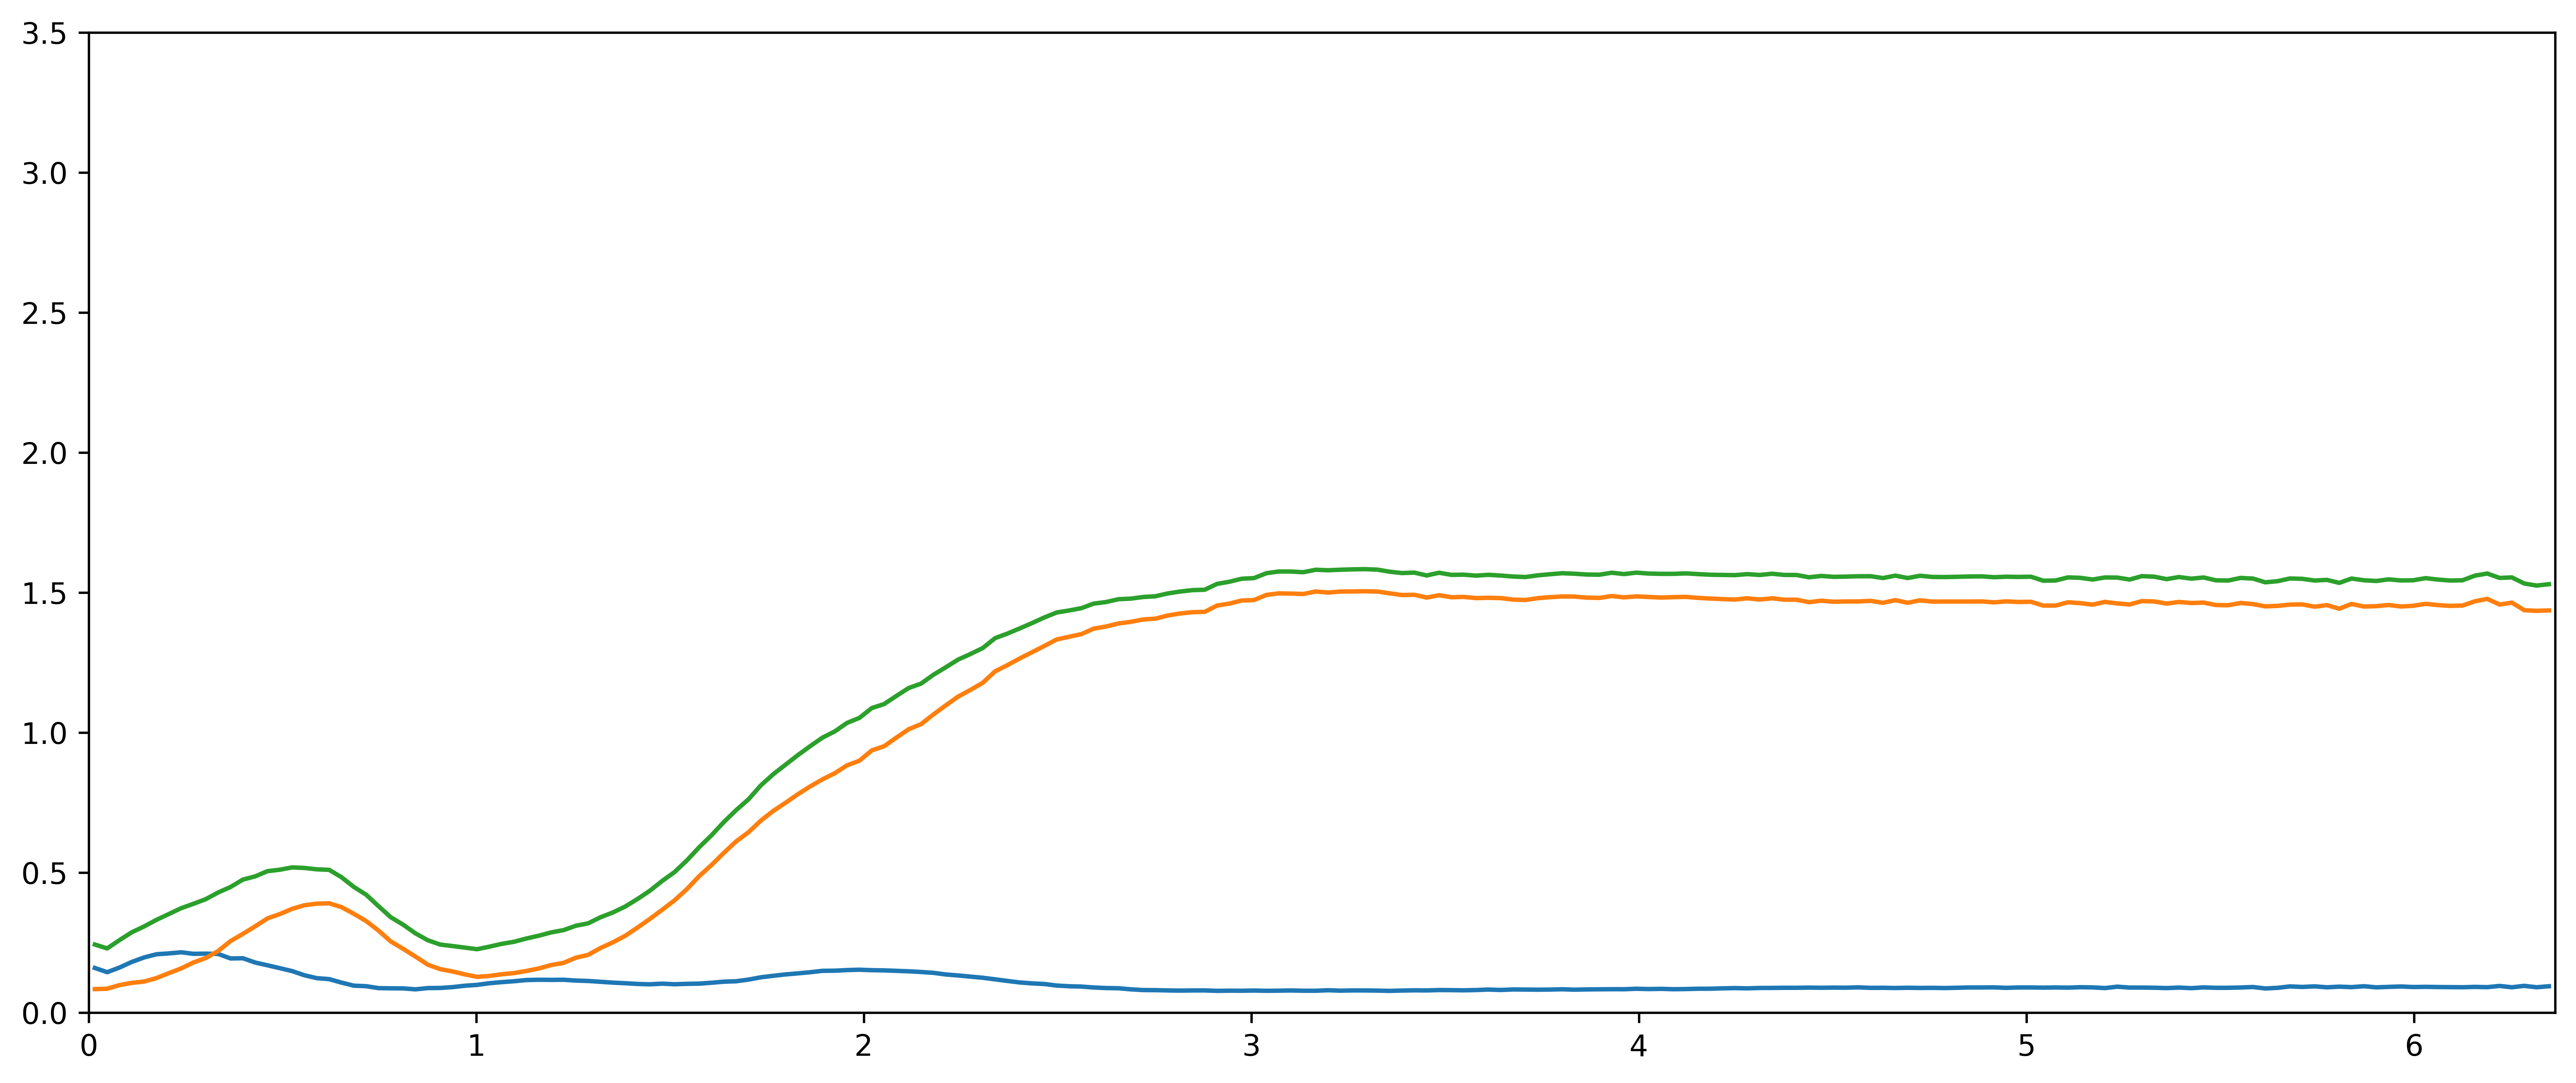

1.437164
bulk: 0.05619328171675122
nearprot: 0.12624421383237105
1.5962588535741464
0.7105198783276836


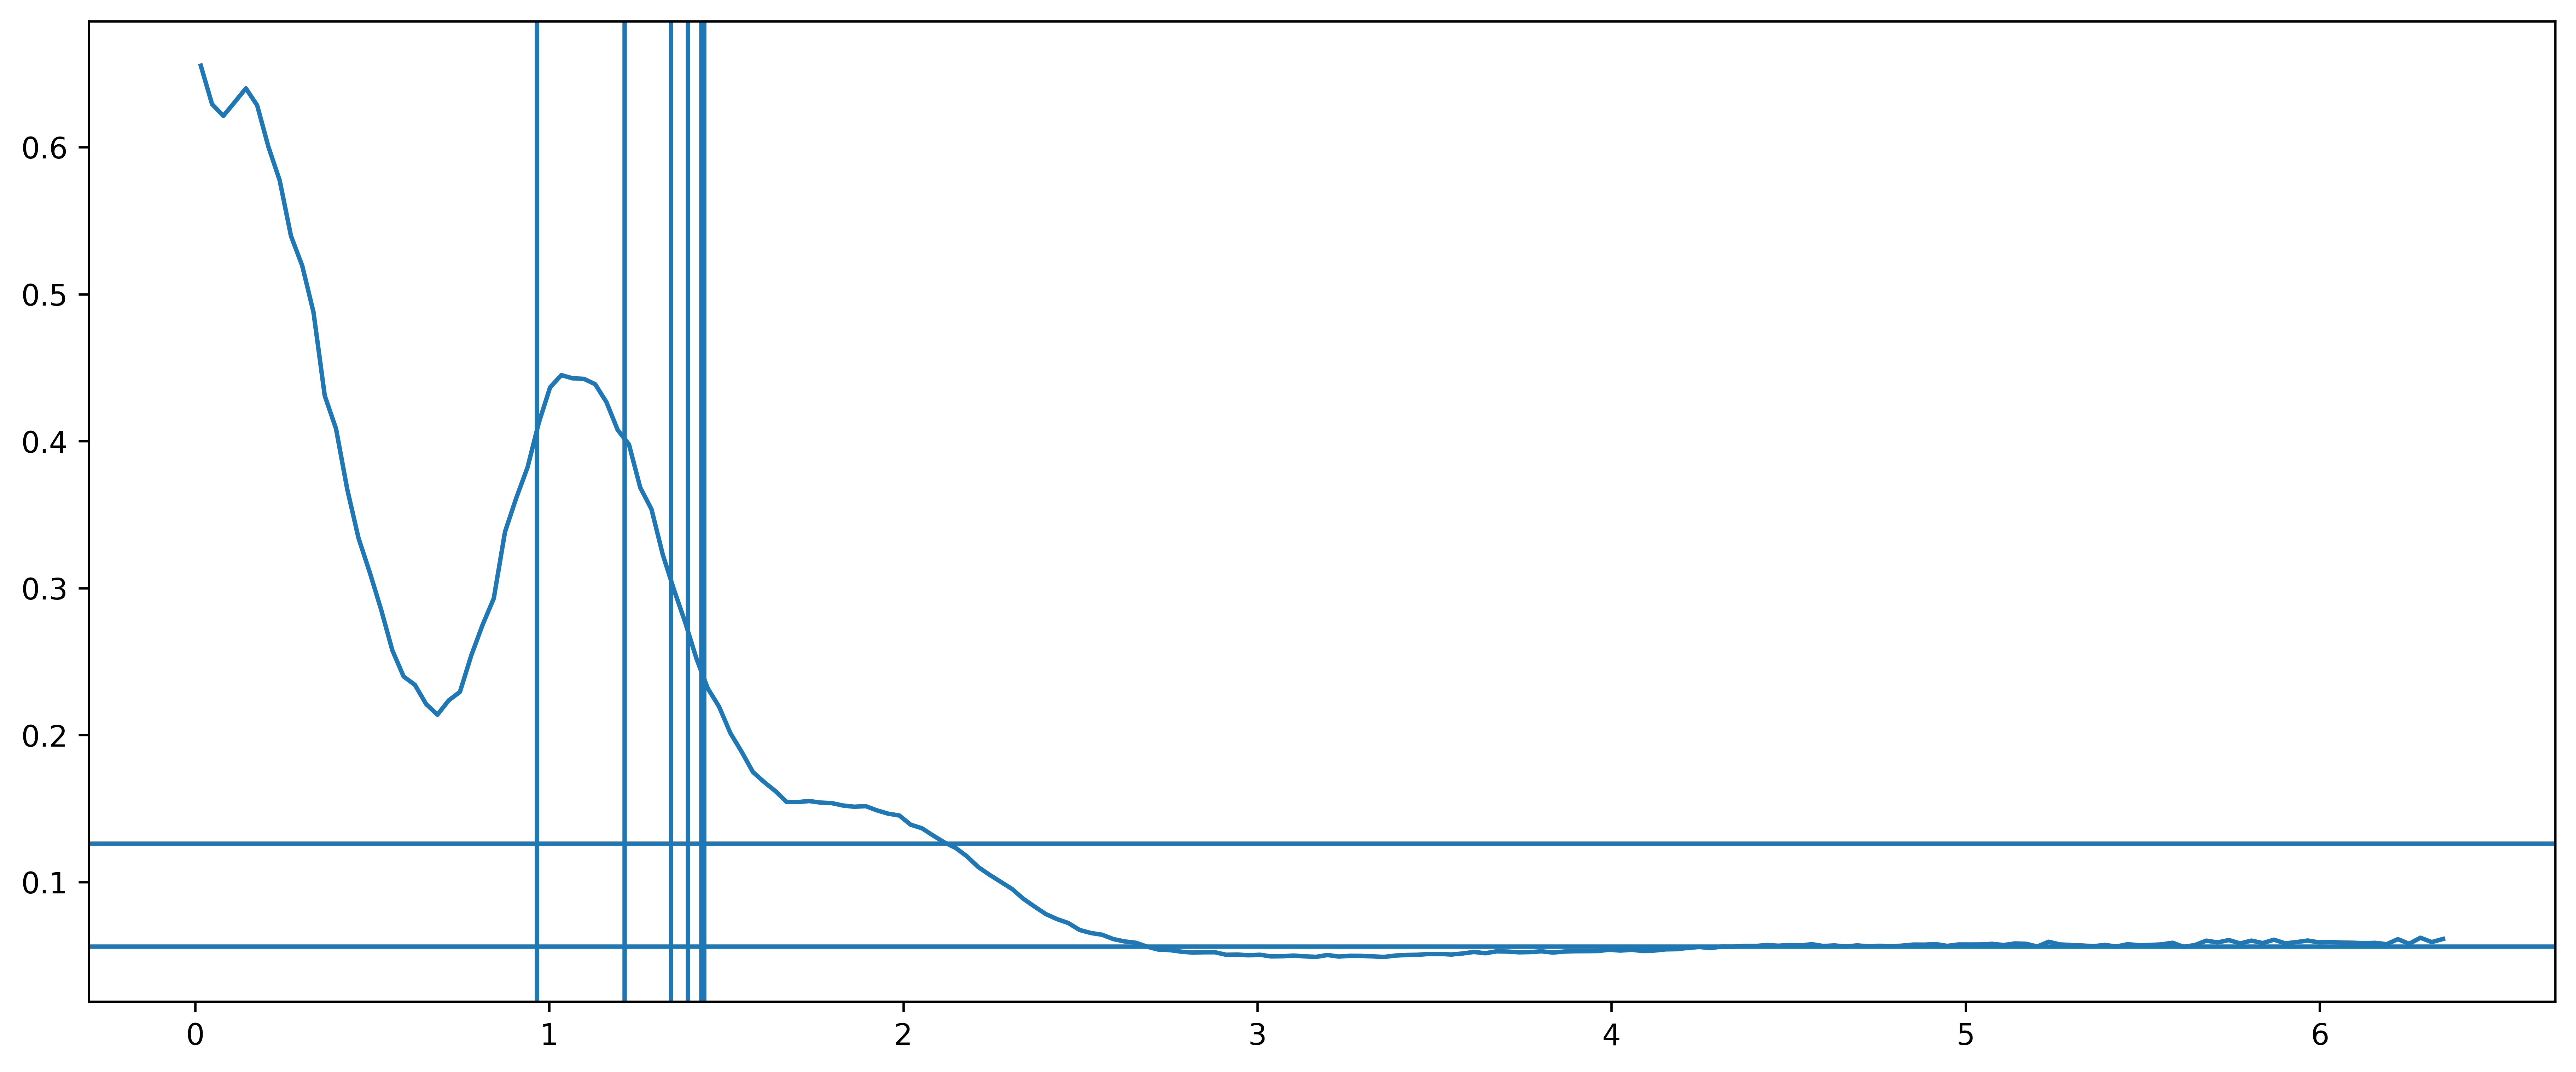

In [11]:

def rdf_2_mol_fractions(protein, leaflet):

    inputpath = "/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/rdfs/outputs"

    servers = ["wynton", "degrabo"]

    bincenters_all = []
    aa_rdf_all = []
    popc_rdf_all = []
    helices_all = []

    for server in servers:
        for run in range(1,5):
            if server == "degrabo" and run > 2:
                continue

            bincenters = np.load(f"{inputpath}/{server}/{protein}/run0{run}/{protein}-{server}-run{str(run).zfill(2)}-ARAN-{leaflet}-bincenters.npy")
            aa_rdf = np.load(f"{inputpath}/{server}/{protein}/run0{run}/{protein}-{server}-run{str(run).zfill(2)}-ARAN-{leaflet}-rdf.npy")
            popc_rdf = np.load(f"{inputpath}/{server}/{protein}/run0{run}/{protein}-{server}-run{str(run).zfill(2)}-POPC-{leaflet}-rdf.npy")
            helices = np.load(f"{inputpath}/{server}/{protein}/run0{run}/{protein}-{server}-run{str(run).zfill(2)}-ARAN-{leaflet}-helix-radii.npy")
        
            aa_rdf_all.append(aa_rdf[-1])
            popc_rdf_all.append(popc_rdf[-1])
            bincenters_all.append(bincenters[-1])
            helices_all.append(helices[-1])


    #simulation length (*100 ps) by simulation and protein
    nframes = {"aac1":[35242, 35336, 58325/2, 58169/2, 25043, 37351], "ucp1":[37084, 36265, 55026/2, 48309/2, 32256, 29577]}

    #average across 6 runs
    bincenters = bincenters_all[0] #all runs use the same bincenters
    mean_helix_radii = np.mean(np.stack(helices_all), axis = 0)
    mean_aa_density = np.average(np.stack(aa_rdf_all), axis = 0, weights = nframes[protein])
    mean_popc_density = np.average(np.stack(popc_rdf_all), axis = 0, weights = nframes[protein])

    total_molar_density = mean_aa_density+mean_popc_density
    
    plt.figure(figsize = (15,6), dpi=600)

    plt.plot(bincenters, mean_aa_density)
    plt.plot(bincenters, mean_popc_density)
    plt.plot(bincenters, total_molar_density)
    plt.ylim(0,3.5)
    plt.xlim(0,6.364)
    plt.show()

    #calculate mole fraction of AA as a function of radius
    mole_fraction_aa = [aad/ttd for aad, ttd in zip(mean_aa_density, total_molar_density)]

    plt.figure(figsize = (15,6), dpi=600)

    plt.plot(bincenters, mole_fraction_aa)

    #print(np.stack(helices_all))

    #calculate mean h
    for hi in mean_helix_radii:
        plt.axvline(hi)

    #calculate mole fraction of AA in the near-protein and bulk membrane
    if leaflet == "upper":
        prot_zone_min = np.max(mean_helix_radii) #need a different number for M side, 2 would probably work
    elif leaflet == "lower":
        prot_zone_min = 2
        
    print(prot_zone_min)
    bulk_min = {"aac1":3.75, "ucp1":3}
    prot_zone_length = 1 #{"aac1":1, "ucp1":1}

    aa_nearprot = 0
    aa_bulk = 0
    popc_nearprot = 0
    popc_bulk = 0
    
    for bc, aa_density, popc_density in zip(bincenters, mean_aa_density, mean_popc_density):
        if bc >= prot_zone_min and bc < prot_zone_min + prot_zone_length:
            aa_nearprot += bc*aa_density
            popc_nearprot += bc*popc_density
        elif bc >= bulk_min[protein]:
            aa_bulk += bc*aa_density
            popc_bulk += bc*popc_density            

    bulk_mol_fraction = aa_bulk/(aa_bulk+popc_bulk)
    nearprot_mol_fraction = aa_nearprot/(aa_nearprot+popc_nearprot)

    plt.axhline(bulk_mol_fraction)
    plt.axhline(nearprot_mol_fraction)

    print(f"bulk: {bulk_mol_fraction}")
    print(f"nearprot: {nearprot_mol_fraction}")

    #number of aa w/in 1 nm of protein vs the number one would expect to find there based on bulk concentrations
    n_aa_nearprot = 2*np.pi*(bincenters[1]-bincenters[0])*aa_nearprot
    print(n_aa_nearprot)
    print(n_aa_nearprot*bulk_mol_fraction/nearprot_mol_fraction)
    
    #print(2*np.pi*(bincenters[1]-bincenters[0])*aa_bulk)
    
    plt.show()
    # plt.plot([bincenters[i+1]-bincenters[i] for i in range(len(bincenters)-1)])


    #print(np.pi*nearprot_mol_fraction*((prot_zone_min+1)**2 - prot_zone_min**2))
    #print(np.pi*bulk_mol_fraction*((prot_zone_min+1)**2 - prot_zone_min**2))


proteins = ["aac1", "ucp1"]
leaflets = ["upper", "lower"]

rdf_2_mol_fractions("ucp1", "upper")

null POPC
<generator object compile_rdfs.<locals>.<genexpr> at 0x7a5de7baa180>


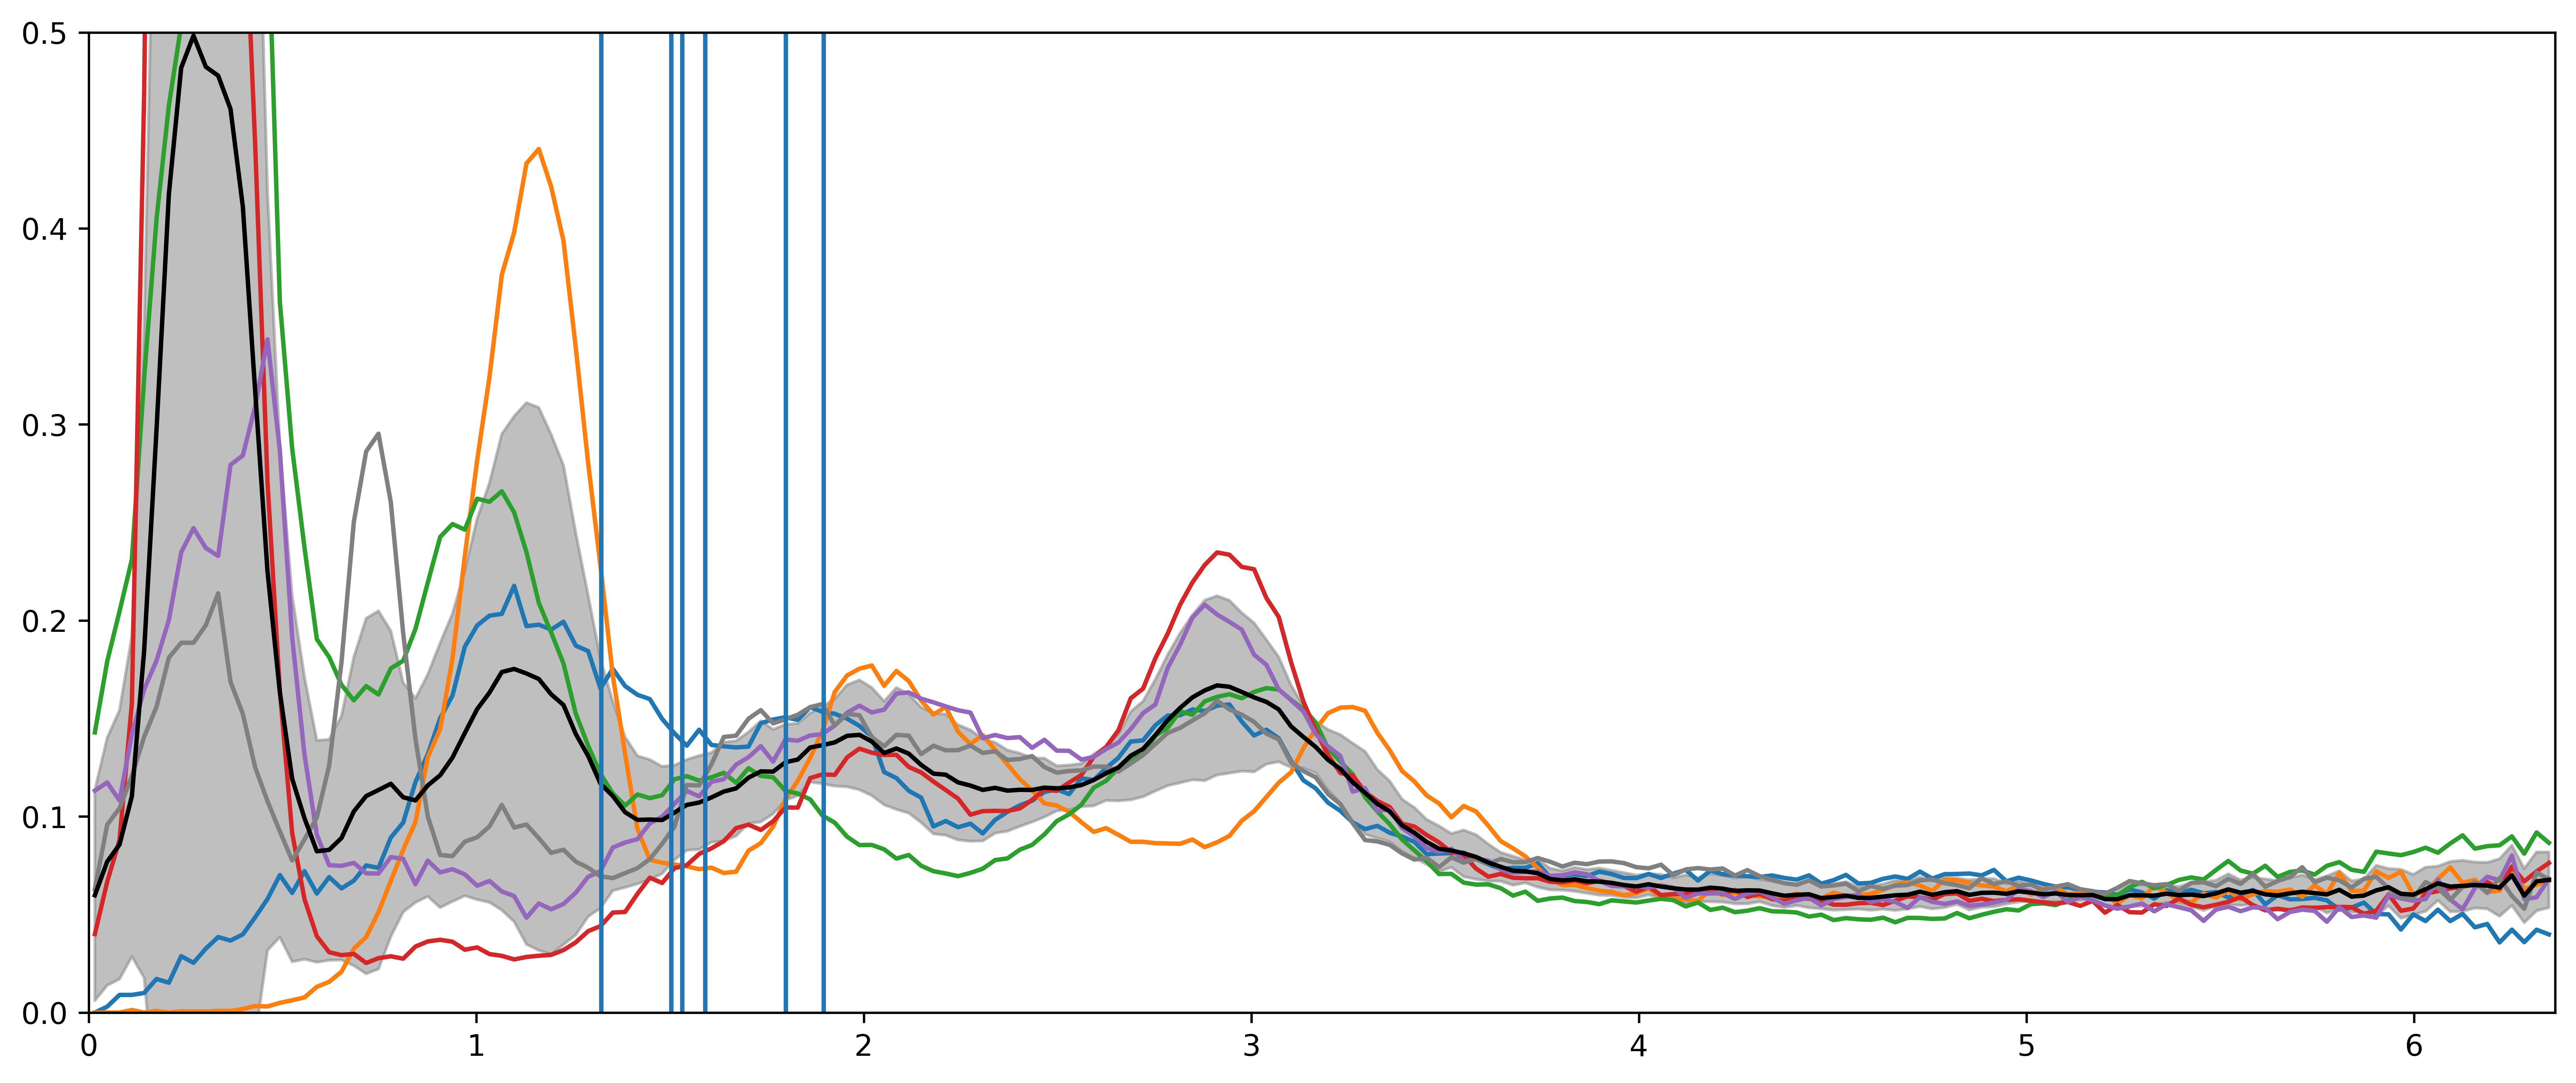

null POPC
<generator object compile_rdfs.<locals>.<genexpr> at 0x7a5de94034c0>


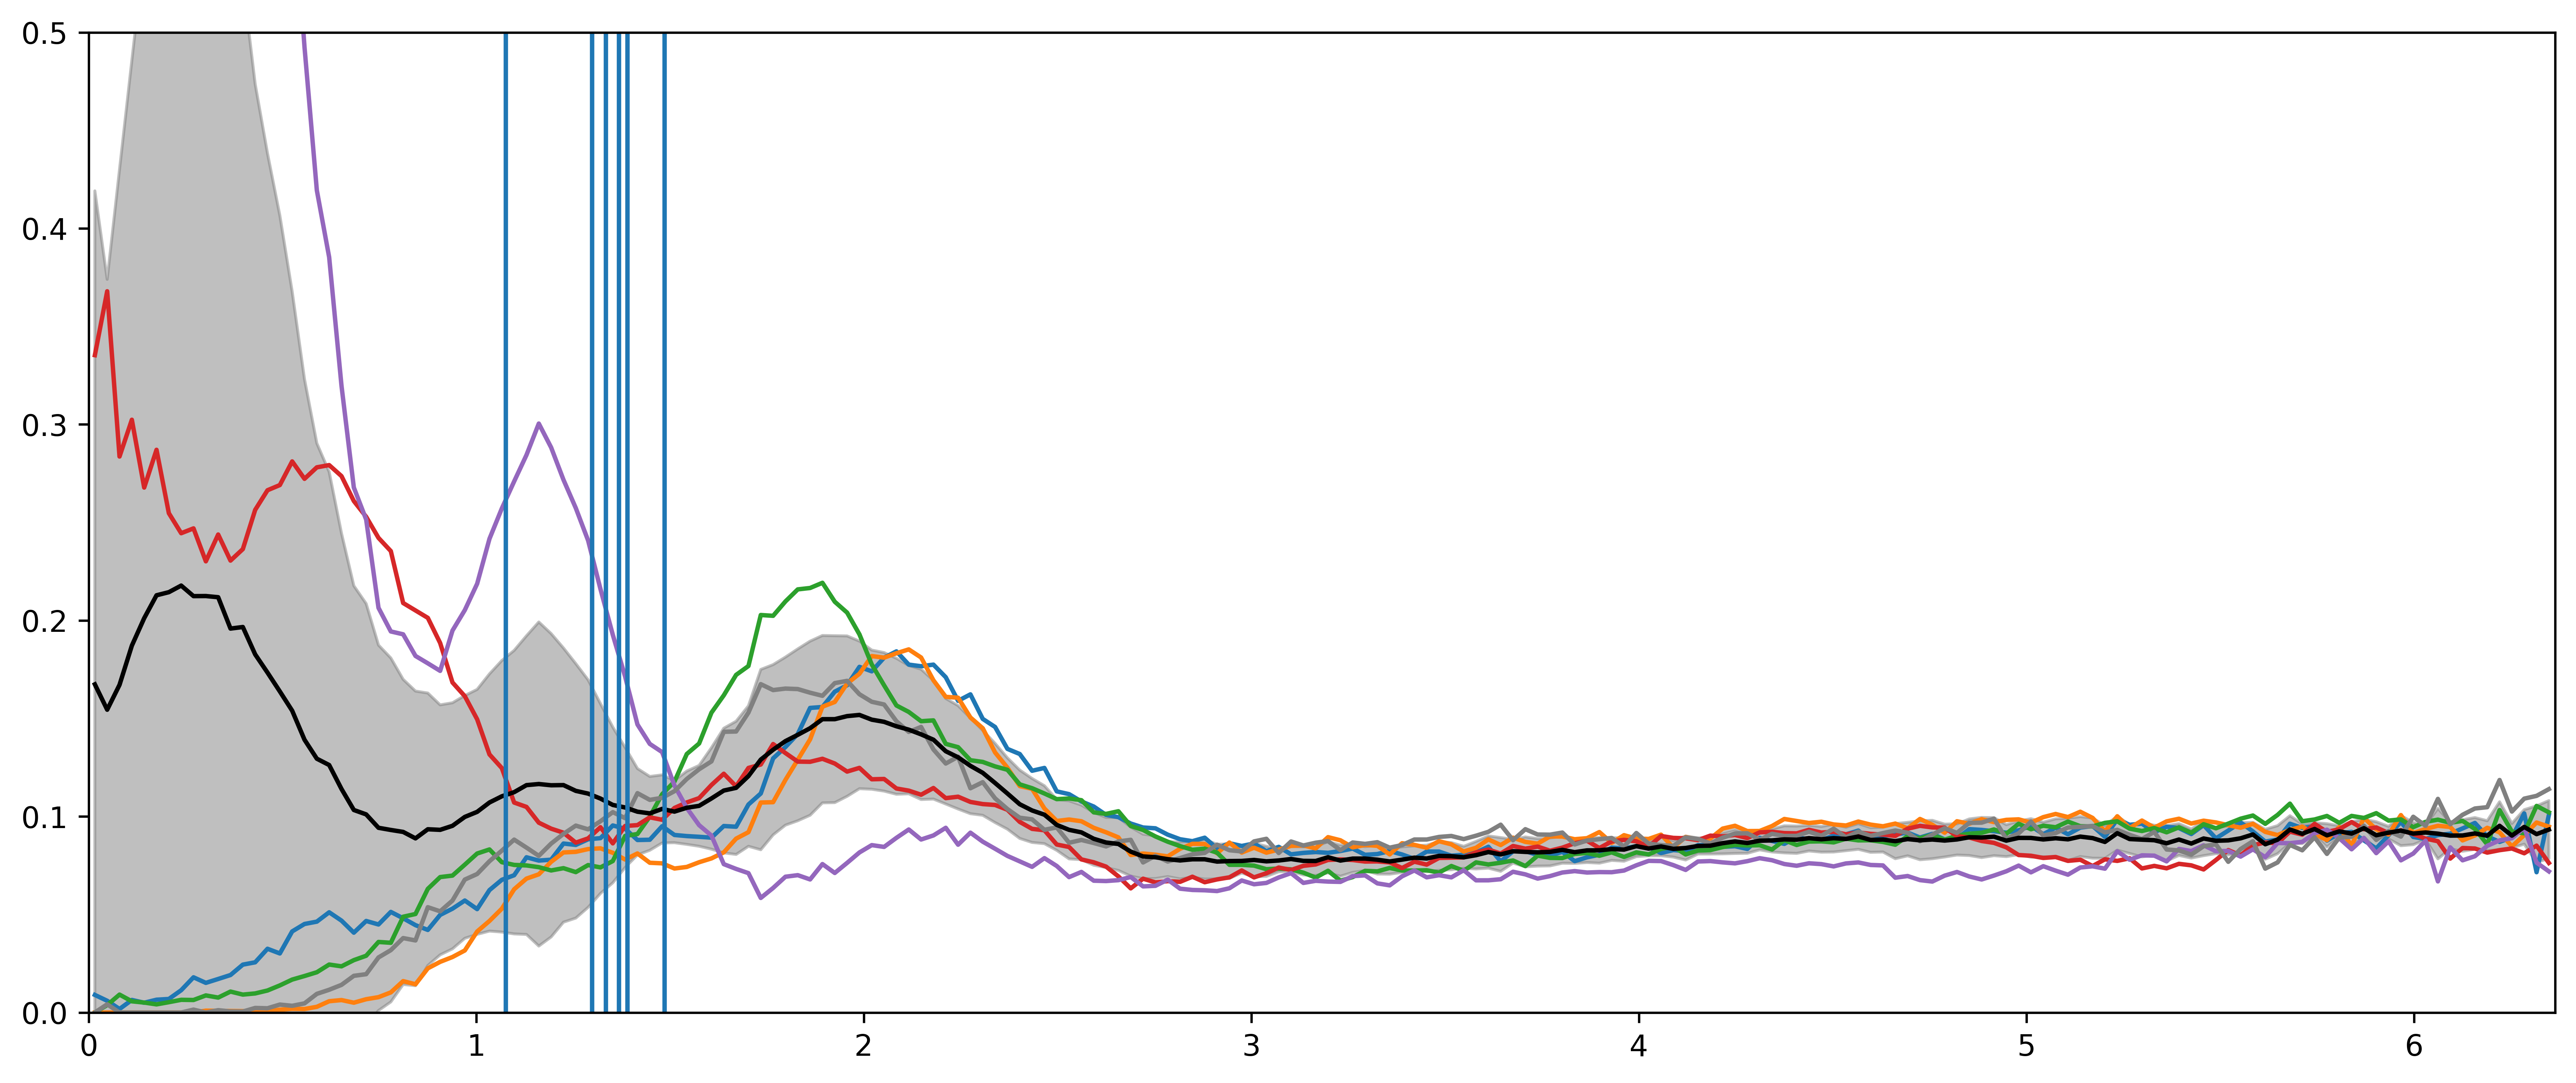

In [37]:

convergence = False

colors = ["C0", "C1", "C2", "C3", "C4", "grey"]
# pdbids = {"aac1": "2C3E", "ucp1": "8HBV"}

def compile_rdfs(resn, leaflet):

    inputpath = "/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/rdfs/outputs"

    servers = ["wynton", "degrabo"]
    proteins = ["aac1", "ucp1"]

    #loop over servers, proteins, and parallel runs
    for protein in proteins:

        ci = 1
        plt.figure(figsize = (15,6), dpi=600)
        bincenters_all = []
        rdf_all = []
        helices_all = []

        legend = []

        for server in servers:
            for run in range(1,5):
                if server == "degrabo" and run > 2:
                    continue

                bincenters = np.load(f"{inputpath}/{server}/{protein}/run0{run}/{protein}-{server}-run{str(run).zfill(2)}-{resn}-{leaflet}-bincenters.npy")
                rdf = np.load(f"{inputpath}/{server}/{protein}/run0{run}/{protein}-{server}-run{str(run).zfill(2)}-{resn}-{leaflet}-rdf.npy")
                helices = np.load(f"{inputpath}/{server}/{protein}/run0{run}/{protein}-{server}-run{str(run).zfill(2)}-{resn}-{leaflet}-helix-radii.npy")
                
                # print(helices)
                # print(helices.shape)
                # print(bincenters)
                # print(rdf)

                if convergence:
                    cc = 0
                    for bc, rd, hc in zip(bincenters, rdf, helices):
                        plt.plot(bc, rd, color = str(cc/12))
                        plt.axvline(np.mean(hc))

                        cc+= 1

                    plt.show()

                else:
                    plt.plot(bincenters[-1], rdf[-1], color = colors[ci-1])
                    legend.append(f"{server} run {run}")

                    rdf_all.append(rdf[-1])
                    bincenters_all.append(bincenters[-1])
                    helices_all.append(helices[-1])

                    # for hci in helices[-1]:
                    #     plt.axvline(hci)


                ci += 1


        if not convergence:

            #plt.legend(legend)
            plt.ylim(0,0.5)
            plt.xlim(0,6.364)

            #print(bincenters_all)
            bincenterss = np.mean(np.stack(bincenters_all), axis = 0)
            meand = np.mean(np.stack(rdf_all), axis = 0)
            stdd = np.std(np.stack(rdf_all), axis = 0)
            plt.plot(bincenterss, meand, color = "black") #yerr = stdd, 

            plt.fill_between(bincenterss, meand+stdd, meand-stdd, color="grey", alpha = 0.5)

            helicess = np.mean(np.stack(helices), axis = 0)
            #print(protein + ": " + str(np.max(helicess)))
            for hi in helicess:
                plt.axvline(hi)

            area = (2*4.6)**2 - np.pi*np.max(helicess)**2
            n_aa = 8

            null_density = n_aa/area
            print(f"null POPC")
            #plt.axhline(null_density)

            prot_zone_min = np.max(helicess)
            prot_zone_max = {"aac1":3.75, "ucp1":2.75}

            print(bincenters[i+1]-bincenters[i] for i in range(len(bincenters)-1))

            aa_nearprot = 0
            aa_bulk = 0
            popc_nearprot = 0
            popc_bulk = 0
            
            # for bc, density in zip(bincenterss, meand):

            #     if bc >= prot_zone_min and bc < prot_zone_max:
            #         aa_nearprot += bc*density
            #     elif bc >= prot_zone_max:


            plt.show()

                #sys.exit(0)

                

compile_rdfs("ARAN", "upper")

In [49]:
#maths

protein = "ucp1"

max_helices = {"aac1":1.89, "ucp1":1.49}
n_aa = 8

area = (2*4.6)**2 - np.pi*max_helices[protein]**2

print(n_aa/area)

0.10300603788656423


In [ ]:
        #plt.axhline(0.33, 0, 8, color="black")
        # plt.xlim(0,7.5)
        # plt.ylim(0,0.5)
        # plt.legend(legend)
        # plt.title(f"{protein} RMSD")
        # plt.xlabel ("Time (µs)")
        # plt.ylabel (f"C-alpha RMSD to PDB {pdbids[protein]} (nm)")
 
        # plt.savefig(f"{inputpath}/rmsd_{protein}.png", bbox_inches='tight', format ='png')

        # plt.show()

        #print(wire_fractions)
        #print(f"wire forms {np.round(np.mean(wire_fractions), 4)}+={np.round(np.std(wire_fractions), 4)} of the time")



                # #step is in microseconds
                # if server == "wynton" and (run == 3 or run == 4):
                #     step = 1/10000
                # else:
                #     step = 1/5000

                # dists = []
 
                # for seg in range(1,20):

                #     file = f"{inputpath}/{server}/{protein}/run0{run}/{protein}-{server}-run{str(run).zfill(2)}-seg{str(seg).zfill(2)}-rmsd.npy"

                #     if os.path.exists(file):
                #         dists.append(np.load(file))

                # dists = np.concatenate(dists)
                # #print(min(dists))
                # smoothed_dists = [np.mean(dists[i:i+window]) for i in range(len(dists)-window)]

                # plt.plot([i*step for i in range(len(smoothed_dists))], smoothed_dists, linewidth = 1.5, color = colors[ci])

                # #plt.plot([i*step for i in range(len(dists))], dists, linewidth = 0.5)
                # legend.append(f"{server} run {run}")
                # #plt.show()